# Path Engineering Experiments
This notebook runs the end-to-end experiments for manipulating hidden-state path space via PCA-based interventions.

In [1]:
import os
import json
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, default_data_collator

sns.set_theme(style="whitegrid")

SEED = 42
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
MAX_LENGTH = 128
BATCH_SIZE = 32
PCA_SAMPLE_SIZE = 2000
TOP_K = 128
BOTTOM_K = 64
NOISE_SCALE = 0.08
BOOST_FACTOR = 1.8
RESULTS_DIR = Path("results")
PLOTS_DIR = RESULTS_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cpu")
print(f"Using device: {device}")


/data/hypogenicai/workspaces/path-engineering-nlp-6e02/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data/hypogenicai/workspaces/path-engineering-nlp-6e02/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cpu


In [2]:
raw_datasets = load_dataset("glue", "sst2")

train_ds = raw_datasets["train"].map(lambda example, idx: {"row_id": idx}, with_indices=True)
val_ds = raw_datasets["validation"].map(lambda example, idx: {"row_id": idx}, with_indices=True)

val_text_lookup = {ex["row_id"]: ex["sentence"] for ex in val_ds}

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch["sentence"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

train_tok = train_ds.map(tokenize_fn, batched=True)
val_tok = val_ds.map(tokenize_fn, batched=True)

cols = ["input_ids", "attention_mask", "label", "row_id"]
train_tok.set_format(type="torch", columns=cols)
val_tok.set_format(type="torch", columns=cols)

print(train_tok)
print(val_tok)


Dataset({
    features: ['sentence', 'label', 'idx', 'row_id', 'input_ids', 'attention_mask'],
    num_rows: 67349
})
Dataset({
    features: ['sentence', 'label', 'idx', 'row_id', 'input_ids', 'attention_mask'],
    num_rows: 872
})


In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_tok, batch_size=BATCH_SIZE, shuffle=False, collate_fn=default_data_collator)
val_loader = DataLoader(val_tok, batch_size=BATCH_SIZE, shuffle=False, collate_fn=default_data_collator)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)
model.eval()
print(model.__class__.__name__)


DistilBertForSequenceClassification


In [4]:
def collect_cls_vectors(loader, sample_size):
    collected = []
    total = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
            cls_hidden = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
            collected.append(cls_hidden)
            total += cls_hidden.shape[0]
            if total >= sample_size:
                break
    matrix = np.concatenate(collected, axis=0)[:sample_size]
    return matrix

cls_matrix = collect_cls_vectors(train_loader, PCA_SAMPLE_SIZE)
pca = PCA(n_components=min(cls_matrix.shape[0], cls_matrix.shape[1]), svd_solver="randomized", random_state=SEED)
pca.fit(cls_matrix)
explained = pca.explained_variance_ratio_
print(f"PCA fit on shape {cls_matrix.shape}")


PCA fit on shape (2000, 768)


In [5]:
class PCAHelper:
    def __init__(self, pca_obj, device):
        self.mean = torch.tensor(pca_obj.mean_, dtype=torch.float32, device=device)
        self.components = torch.tensor(pca_obj.components_, dtype=torch.float32, device=device)

    def constrain(self, hidden_states, k):
        comps = self.components[:k]
        centered = hidden_states - self.mean
        coeffs = centered @ comps.T
        recon = coeffs @ comps
        return recon + self.mean

    def expand(self, hidden_states, bottom_k, noise_scale, boost):
        comps = self.components[-bottom_k:]
        centered = hidden_states - self.mean
        coeffs = centered @ comps.T
        amplified = (boost - 1.0) * (coeffs @ comps)
        noise = torch.randn(hidden_states.size(0), bottom_k, device=hidden_states.device) * noise_scale
        noise_proj = noise @ comps
        return hidden_states + amplified + noise_proj

pca_helper = PCAHelper(pca, device)

import torch.nn.functional as F

def forward_from_hidden(hidden_states):
    x = model.pre_classifier(hidden_states)
    x = F.relu(x)
    x = model.dropout(x)
    logits = model.classifier(x)
    return logits


def evaluate_condition(name, intervention_fn=None):
    records = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_tensor = batch.get("labels", batch.get("label"))
            labels = labels_tensor.cpu().numpy()
            row_ids = batch["row_id"].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_cls = outputs.hidden_states[-1][:, 0, :]
            if intervention_fn is not None:
                hidden_cls = intervention_fn(hidden_cls)
            logits = forward_from_hidden(hidden_cls)

            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            preds = probs.argmax(axis=-1)
            logits_np = logits.cpu().numpy()

            for i in range(len(labels)):
                prob = probs[i]
                entropy = -np.sum(prob * np.log(prob + 1e-12))
                one_hot = np.zeros_like(prob)
                one_hot[labels[i]] = 1.0
                brier = np.sum((prob - one_hot) ** 2)
                margin = float(logits_np[i, 1] - logits_np[i, 0])
                rid = int(row_ids[i])
                records.append({
                    "condition": name,
                    "row_id": rid,
                    "label": int(labels[i]),
                    "sentence": val_text_lookup[rid],
                    "prob_pos": float(prob[1]),
                    "entropy": float(entropy),
                    "brier": float(brier),
                    "logit_margin": margin,
                    "pred": int(preds[i])
                })
    df = pd.DataFrame(records)
    return df

baseline_df = evaluate_condition("baseline")
constrained_df = evaluate_condition("constrained_top128", intervention_fn=lambda x: pca_helper.constrain(x, TOP_K))
expanded_df = evaluate_condition(
    "expanded_bottom64",
    intervention_fn=lambda x: pca_helper.expand(x, bottom_k=BOTTOM_K, noise_scale=NOISE_SCALE, boost=BOOST_FACTOR)
)

condition_dfs = {
    "baseline": baseline_df,
    "constrained_top128": constrained_df,
    "expanded_bottom64": expanded_df,
}

{key: df.head() for key, df in condition_dfs.items()}


{'baseline':   condition  row_id  label                                           sentence  \
 0  baseline       0      1    it 's a charming and often affecting journey .    
 1  baseline       1      0                 unflinchingly bleak and desperate    
 2  baseline       2      1  allows us to hope that nolan is poised to emba...   
 3  baseline       3      1  the acting , costumes , music , cinematography...   
 4  baseline       4      0                  it 's slow -- very , very slow .    
 
    prob_pos   entropy         brier  logit_margin  pred  
 0  0.999884  0.001168  2.694660e-08      9.061466     1  
 1  0.001030  0.008117  2.123743e-06     -6.876682     0  
 2  0.999640  0.003214  2.592007e-07      7.929077     1  
 3  0.999699  0.002739  1.808090e-07      8.109094     1  
 4  0.000311  0.002821  1.931872e-07     -8.076013     0  ,
 'constrained_top128':             condition  row_id  label  \
 0  constrained_top128       0      1   
 1  constrained_top128       1     

In [6]:
def summarize_condition(df):
    acc = (df["pred"] == df["label"]).mean()
    return {
        "accuracy": float(acc),
        "mean_entropy": float(df["entropy"].mean()),
        "mean_brier": float(df["brier"].mean()),
        "mean_margin": float(df["logit_margin"].mean()),
        "median_entropy": float(df["entropy"].median()),
    }

metrics = {name: summarize_condition(df) for name, df in condition_dfs.items()}
metrics_df = pd.DataFrame(metrics).T
metrics_df


,accuracy,mean_entropy,mean_brier,mean_margin,median_entropy
baseline,0.91055,0.047108,0.166734,0.776102,0.004350
constrained_top128,0.91055,0.047143,0.166686,0.776300,0.004293
expanded_bottom64,0.91055,0.047138,0.166723,0.775805,0.004344


In [7]:
def paired_stats(target_df, baseline_df, metric):
    diff = target_df[metric].values - baseline_df[metric].values
    ttest = stats.ttest_rel(target_df[metric], baseline_df[metric])
    d = diff.mean() / diff.std(ddof=1)
    def bootstrap_ci(values, n_boot=1000):
        rng = np.random.default_rng(SEED)
        boot = []
        for _ in range(n_boot):
            sample = rng.choice(values, size=values.shape[0], replace=True)
            boot.append(sample.mean())
        return (float(np.percentile(boot, 2.5)), float(np.percentile(boot, 97.5)))
    ci = bootstrap_ci(diff)
    return {
        "mean_diff": float(diff.mean()),
        "cohens_d": float(d),
        "p_value": float(ttest.pvalue),
        "ci95": ci,
    }

entropy_stats = {
    "constrained_vs_baseline": paired_stats(constrained_df, baseline_df, "entropy"),
    "expanded_vs_baseline": paired_stats(expanded_df, baseline_df, "entropy"),
}

# McNemar-style table for accuracy differences
from math import isclose

def mcnemar_p(b_df, t_df):
    b_correct = (b_df["pred"] == b_df["label"]).values
    t_correct = (t_df["pred"] == t_df["label"]).values
    b_only = np.logical_and(b_correct, np.logical_not(t_correct)).sum()
    t_only = np.logical_and(t_correct, np.logical_not(b_correct)).sum()
    denom = b_only + t_only
    if denom == 0:
        return 1.0
    chi2 = (abs(b_only - t_only) - 1) ** 2 / denom
    from scipy.stats import chi2 as chi2_dist
    return float(chi2_dist.sf(chi2, 1))

accuracy_stats = {
    "constrained_vs_baseline": {
        "acc_diff": float(constrained_df["pred"].eq(constrained_df["label"]).mean() - baseline_df["pred"].eq(baseline_df["label"]).mean()),
        "p_value": mcnemar_p(baseline_df, constrained_df),
    },
    "expanded_vs_baseline": {
        "acc_diff": float(expanded_df["pred"].eq(expanded_df["label"]).mean() - baseline_df["pred"].eq(baseline_df["label"]).mean()),
        "p_value": mcnemar_p(baseline_df, expanded_df),
    }
}

entropy_stats, accuracy_stats


({'constrained_vs_baseline': {'mean_diff': 3.5274474654098925e-05,
   'cohens_d': 0.016301206666598518,
   'p_value': 0.6303752703812129,
   'ci95': (-0.00011020893500511718, 0.00018128651754189396)},
  'expanded_vs_baseline': {'mean_diff': 2.9808171723601877e-05,
   'cohens_d': 0.08639990380598159,
   'p_value': 0.010900249761457998,
   'ci95': (7.786788336730803e-06, 5.476204528558226e-05)}},
 {'constrained_vs_baseline': {'acc_diff': 0.0, 'p_value': 1.0},
  'expanded_vs_baseline': {'acc_diff': 0.0, 'p_value': 1.0}})

/tmp/ipykernel_1711298/814822753.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_long, x="condition", y="mean_entropy", palette="viridis")


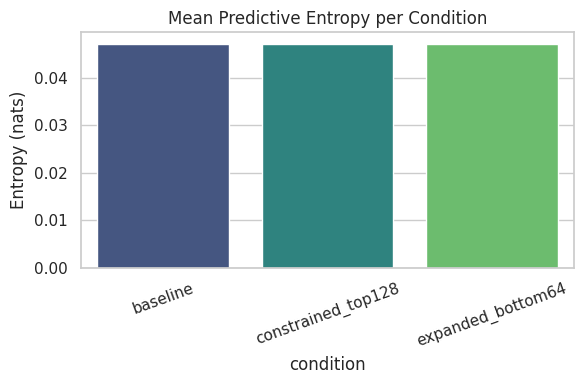

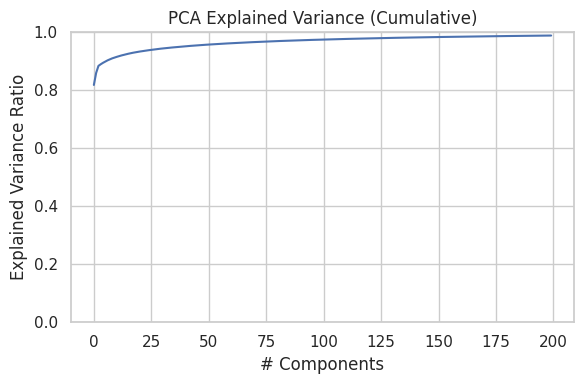

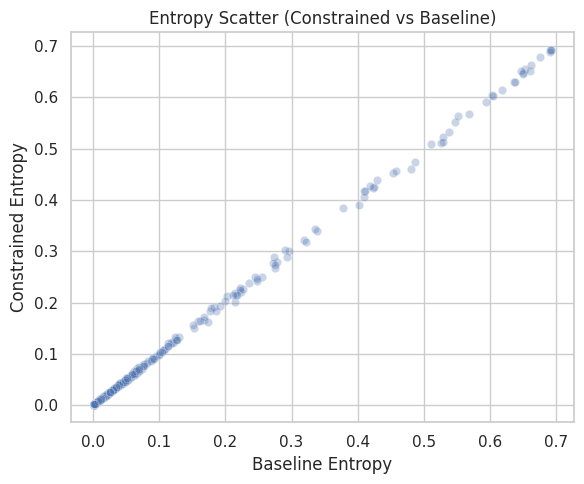

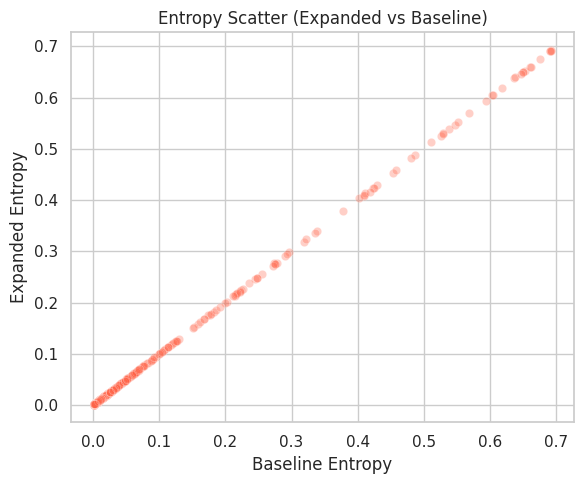

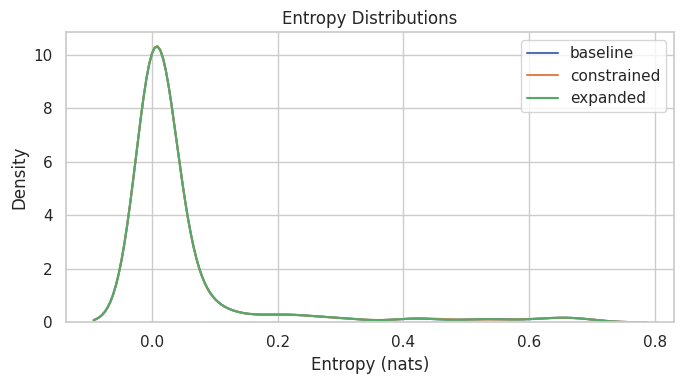

In [8]:
# Visualizations
order = ["baseline", "constrained_top128", "expanded_bottom64"]
metrics_long = metrics_df.loc[order].reset_index().rename(columns={"index": "condition"})
plt.figure(figsize=(6,4))
sns.barplot(data=metrics_long, x="condition", y="mean_entropy", palette="viridis")
plt.title("Mean Predictive Entropy per Condition")
plt.xticks(rotation=20)
plt.ylabel("Entropy (nats)")
plt.tight_layout()
entropy_bar_path = PLOTS_DIR / "entropy_bar.png"
plt.savefig(entropy_bar_path, dpi=200)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.arange(len(explained[:200])), np.cumsum(explained[:200]))
plt.title("PCA Explained Variance (Cumulative)")
plt.xlabel("# Components")
plt.ylabel("Explained Variance Ratio")
plt.ylim(0,1)
plt.tight_layout()
pca_curve_path = PLOTS_DIR / "pca_variance.png"
plt.savefig(pca_curve_path, dpi=200)
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x=baseline_df["entropy"], y=constrained_df["entropy"], alpha=0.3)
plt.xlabel("Baseline Entropy")
plt.ylabel("Constrained Entropy")
plt.title("Entropy Scatter (Constrained vs Baseline)")
plt.tight_layout()
scatter_constrained_path = PLOTS_DIR / "entropy_scatter_constrained.png"
plt.savefig(scatter_constrained_path, dpi=200)
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x=baseline_df["entropy"], y=expanded_df["entropy"], alpha=0.3, color="tomato")
plt.xlabel("Baseline Entropy")
plt.ylabel("Expanded Entropy")
plt.title("Entropy Scatter (Expanded vs Baseline)")
plt.tight_layout()
scatter_expanded_path = PLOTS_DIR / "entropy_scatter_expanded.png"
plt.savefig(scatter_expanded_path, dpi=200)
plt.show()

plt.figure(figsize=(7,4))
for df, label in [(baseline_df, "baseline"), (constrained_df, "constrained"), (expanded_df, "expanded")]:
    sns.kdeplot(df["entropy"], label=label)
plt.title("Entropy Distributions")
plt.xlabel("Entropy (nats)")
plt.legend()
plt.tight_layout()
entropy_density_path = PLOTS_DIR / "entropy_density.png"
plt.savefig(entropy_density_path, dpi=200)
plt.show()


In [9]:
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

metrics_path = RESULTS_DIR / "metrics.json"
with metrics_path.open("w") as f:
    json.dump(metrics, f, indent=2)

stats_path = RESULTS_DIR / "statistics.json"
stats_content = {
    "entropy": entropy_stats,
    "accuracy": accuracy_stats,
}
with stats_path.open("w") as f:
    json.dump(stats_content, f, indent=2)

pca_info_path = RESULTS_DIR / "pca_info.json"
pca_info = {
    "explained_variance_ratio": explained[:200].tolist(),
    "top_k": TOP_K,
    "bottom_k": BOTTOM_K,
    "noise_scale": NOISE_SCALE,
    "boost_factor": BOOST_FACTOR,
}
with pca_info_path.open("w") as f:
    json.dump(pca_info, f, indent=2)

base_cols = ["row_id", "label", "sentence"]
merged = baseline_df[base_cols].copy()
for name, df in condition_dfs.items():
    suffix = name
    subset = df[["row_id", "prob_pos", "entropy", "brier", "logit_margin", "pred"]].copy()
    subset.columns = [
        "row_id",
        f"{suffix}_prob_pos",
        f"{suffix}_entropy",
        f"{suffix}_brier",
        f"{suffix}_margin",
        f"{suffix}_pred",
    ]
    merged = merged.merge(subset, on="row_id", how="left")

per_sample_path = RESULTS_DIR / "per_sample_metrics.csv"
merged.to_csv(per_sample_path, index=False)

config_path = RESULTS_DIR / "config.json"
config = {
    "seed": SEED,
    "model_name": MODEL_NAME,
    "max_length": MAX_LENGTH,
    "batch_size": BATCH_SIZE,
    "pca_sample_size": PCA_SAMPLE_SIZE,
}
with config_path.open("w") as f:
    json.dump(config, f, indent=2)

metrics_df


,accuracy,mean_entropy,mean_brier,mean_margin,median_entropy
baseline,0.91055,0.047108,0.166734,0.776102,0.004350
constrained_top128,0.91055,0.047143,0.166686,0.776300,0.004293
expanded_bottom64,0.91055,0.047138,0.166723,0.775805,0.004344
